### Spectral analysis on simulated data

We can simulate EEG-like data using the GDa package using the methods in **GDa.signal.simulate_data**, this data can be used to test different methods. In the current notebook we use simulated data to test the spectral analysis methods.

In [1]:
import sys
sys.path.insert(1, '/home/vinicius/storage1/projects/GrayData-Analysis')

import time
import scipy
import h5py
import numpy                 as     np
import xarray                as     xr
import pandas                as     pd
import matplotlib.pyplot     as     plt
from   tqdm                      import tqdm
from   xfrites.conn.conn_coh     import conn_coherence_wav, _tf_decomp
from   GDa.signal.simulate_data  import white_noise, pink_noise, \
                                        ongoing_non_stationary, \
                                        transient_oscillation_gauss, transient_oscillation_gauss_non_stationary

#### Function to visualize the data

In [2]:
def plot_data(data_array, chan, fs, n):
    assert type(data_array)==xr.core.dataarray.DataArray, 'Data should be an xarray'
    plt.subplot2grid( (3,3), (0,0), colspan=3 )
    for i in range(data_array.shape[0]):
        plt.plot(data_array.time.values, data_array[i,chan,:], color='b', lw=.2)
    plt.plot(data_array.time.values, data_array[:,chan,:].mean(dim='trials'), color = 'r', lw=3)
    plt.xlim([data_array.time.values.min(), data_array.time.values.max()])
    plt.ylabel('Amplitude', fontsize=12)
    plt.xlabel('Time (s)', fontsize=12)
    plt.subplot2grid( (3,3), (1,0) )
    plt.hist(data_array[:,:,:].values.flatten(), 50)
    plt.ylabel('#', fontsize=12)
    plt.xlabel('Amplitude', fontsize=12)    
    plt.subplot2grid( (3,3), (1,1), colspan=2 )
    data_fft = np.fft.fft( data_array[:,chan,:].values, axis = -1)
    s = np.abs(data_fft) / n
    s[1:] = 2*s[1:]
    f = np.linspace(0,fs/2,n//2)
    plt.plot(f, s.real.mean(axis=0)[:n//2])
    plt.xlim([0,f.max()])
    plt.ylabel('Periodogram', fontsize=12)
    plt.xlabel('Freq (Hz)', fontsize=12)
    plt.subplot2grid( (3,3), (2,0), colspan=3 )
    W = _tf_decomp(data_array.values, fs, np.linspace(5,f.max(),100), mode='morlet', n_cycles=6.0,
                   decim=1, kw_cwt={}, kw_mt={}, n_jobs=20)
    S = np.squeeze( W * np.conj(W) ).real
    plt.imshow(S.mean(axis=0), aspect='auto', cmap='jet', origin='lower', 
           extent=[data_array.time.min(),data_array.time.max(),f[0],f[-1]])
    plt.ylabel('Freq (Hz)', fontsize=12)
    plt.xlabel('Time (s)', fontsize=12)
    plt.tight_layout()

#### FRITES coherence implementations

In [3]:
import numpy as np
from scipy.signal import fftconvolve
import xarray as xr

from mne.time_frequency import tfr_array_morlet, tfr_array_multitaper

from frites.io import set_log_level, logger
from frites.utils import parallel_func
from frites.dataset import SubjectEphy


def tf_decomp(data, sf, freqs, mode='morlet', n_cycles=7.0, mt_bandwidth=None,
              decim=1, kw_cwt={}, kw_mt={}, n_jobs=1):
    """Time-frequency decomposition using MNE-Python.
    Parameters
    ----------
    data : array_like
        Electrophysiological data of shape (n_trials, n_chans, n_times)
    sf : float
        Sampling frequency
    freqs : array_like
        Central frequency vector.
    mode : {'morlet', 'multitaper'}
        Spectrum estimation mode can be either: 'multitaper' or 'morlet'.
    n_cycles : array_like | 7.
        Number of cycles to use for each frequency. If a float or an integer is
        used, the same number of cycles is going to be used for all frequencies
    mt_bandwidth : array_like | None
        The bandwidth of the multitaper windowing function in Hz. Only used in
        'multitaper' mode.
    decim : int | 1
        To reduce memory usage, decimation factor after time-frequency
        decomposition. default 1 If int, returns tfr[…, ::decim]. If slice,
        returns tfr[…, decim].
    kw_cwt : dict | {}
        Additional arguments sent to the mne-function
        :py:`mne.time_frequency.tfr_array_morlet`
    kw_mt : dict | {}
        Additional arguments sent to the mne-function
        :py:`mne.time_frequency.tfr_array_multitaper`
    Returns
    -------
    out : array_like
        Time-frequency transform of shape (n_epochs, n_chans, n_freqs, n_times)
    """
    if mode == 'morlet':
        out = tfr_array_morlet(
            data, sf, freqs, n_cycles=n_cycles, output='complex', decim=decim,
            n_jobs=n_jobs, **kw_cwt)
    elif mode == 'multitaper':
        out = tfr_array_multitaper(
            data, sf, freqs, n_cycles=n_cycles, time_bandwidth=mt_bandwidth,
            output='complex', decim=decim, n_jobs=n_jobs, **kw_mt)
    else:
        raise ValueError('Method should be either "morlet" or "multitaper"')

    return out


def create_kernel(sm_times, sm_freqs, kernel='hanning'):
    """2D (freqs, time) smoothing kernel.
    Parameters
    ----------
    sm_times : int
        Number of points to consider for the temporal smoothing
    sm_freqs : int
        Number of points to consider for the frequency smoothing
    kernel : {'square', 'hanning'}
        Kernel type to use. Choose either 'square' or 'hanning'
    Returns
    -------
    kernel : array_like
        Smoothing kernel of shape (sm_freqs, sm_times)
    """
    if kernel == 'square':
        return np.full((sm_freqs, sm_times), 1. / (sm_times * sm_freqs))
    elif kernel == 'hanning':
        hann_t, hann_f = np.hanning(sm_times), np.hanning(sm_freqs)
        hann = hann_f.reshape(-1, 1) * hann_t.reshape(1, -1)
        return hann / np.sum(hann)
    else:
        raise ValueError(f"No kernel {kernel}")


def smooth_spectra(spectra, kernel):
    """Smoothing spectra.
    This function assumes that the frequency and time axis are respectively
    located at positions (..., freqs, times).
    Parameters
    ----------
    spectra : array_like
        Spectra of shape (..., n_freqs, n_times)
    kernel : array_like
        Smoothing kernel of shape (sm_freqs, sm_times)
    Returns
    -------
    sm_spectra : array_like
        Smoothed spectra of shape (..., n_freqs, n_times)
    """
    while kernel.ndim != spectra.ndim:
        kernel = kernel[np.newaxis, ...]
    return fftconvolve(spectra, kernel, mode='same', axes=(-2, -1))


def conn_coherence(data, freqs=None, roi=None, times=None, sfreq=None,
                   pairs=None, sm_times=10, sm_freqs=1, sm_kernel='hanning',
                   mode='morlet', n_cycles=7., mt_bandwidth=None, decim=1,
                   kw_cwt={}, kw_mt={}, n_jobs=-1, verbose=None):
    """Compute the pairwise coherence.
    Parameters
    ----------
    data : array_like
        Electrophysiological data. Several input types are supported :
            * Standard NumPy arrays of shape (n_epochs, n_roi, n_times)
            * mne.Epochs
            * xarray.DataArray of shape (n_epochs, n_roi, n_times)
    freqs : array_like
        Array of frequencies.
    roi : array_like | None
        ROI names of a single subject. If the input is an xarray, the
        name of the ROI dimension can be provided
    times : array_like | None
        Time vector array of shape (n_times,). If the input is an xarray, the
        name of the time dimension can be provided
    sfreq : float
        The sampling frequency
    pairs : array_like | None
        Pairs of contacts
    sm_times : int
        Number of points to consider for the temporal smoothing
    sm_freqs : int
        Number of points to consider for the frequency smoothing
    kernel : {'square', 'hanning'}
        Kernel type to use. Choose either 'square' or 'hanning'
    mode : {'morlet', 'multitaper'}
        Spectrum estimation mode can be either: 'multitaper' or 'morlet'.
    n_cycles : array_like | 7.
        Number of cycles to use for each frequency. If a float or an integer is
        used, the same number of cycles is going to be used for all frequencies
    mt_bandwidth : array_like | None
        The bandwidth of the multitaper windowing function in Hz. Only used in
        'multitaper' mode.
    decim : int | 1
        To reduce memory usage, decimation factor after time-frequency
        decomposition. default 1 If int, returns tfr[…, ::decim]. If slice,
        returns tfr[…, decim].
    kw_cwt : dict | {}
        Additional arguments sent to the mne-function
        :py:`mne.time_frequency.tfr_array_morlet`
    kw_mt : dict | {}
        Additional arguments sent to the mne-function
        :py:`mne.time_frequency.tfr_array_multitaper`
    n_jobs : int | 1
        Number of jobs to use for parallel computing (use -1 to use all
        jobs). The parallel loop is set at the pair level.
    Returns
    -------
    coh : xarray.DataArray
        DataArray of shape (n_trials, n_pairs, n_freqs, n_times)
    """
    set_log_level(verbose)

    # ___________________________________ I/O _________________________________
    if isinstance(data, xr.DataArray):
        trials, attrs = data[data.dims[0]].data, data.attrs
    else:
        trials, attrs = np.arange(data.shape[0]), {}

    # internal conversion
    data = SubjectEphy(data, y=trials, roi=roi, times=times, sfreq=sfreq)
    x, roi, times = data.data, data['roi'].data, data['times'].data[::decim]
    trials, sfreq = data['y'].data, data.attrs['sfreq']
    n_trials, n_roi, n_times = data.shape

    # inputs checking
    assert isinstance(freqs, (np.ndarray, list, tuple))    
    freqs = np.array(freqs)
    n_freqs = len(freqs)

    # get the sorted non-directed pairs and build roi pairs names
    if (pairs is None):
        x_s, x_t = np.triu_indices(n_roi, k=1)
    else:
        assert isinstance(pairs, np.ndarray)
        assert (pairs.ndim == 2) and (pairs.shape[1] == 2)
        x_s, x_t = pairs[:, 0], pairs[:, 1]
    roi_s, roi_t = np.sort(np.c_[roi[x_s], roi[x_t]], axis=1).T
    roi_p = [f"{s}-{t}" for s, t in zip(roi_s, roi_t)]
    n_pairs = len(roi_p)

    # show info
    logger.info(f"Compute pairwise coherence (n_pairs={n_pairs}, "
                f"n_freqs={n_freqs})")
    
    # _____________________________ TIME-FREQUENCY ____________________________
    # time-frequency decomposition
    w = tf_decomp(
        x, sfreq, freqs, n_cycles=n_cycles, decim=decim, mode=mode,
        mt_bandwidth=mt_bandwidth, kw_cwt=kw_cwt, kw_mt=kw_mt, n_jobs=n_jobs)
    # kernel smoothing definition
    kernel = create_kernel(sm_times, sm_freqs, kernel=sm_kernel)

    # ________________________________ COHERENCY ______________________________
    # auto spectra (faster that w * w.conj())
    s_auto = w.real ** 2 + w.imag ** 2
    # smooth the auto spectra
    s_auto = smooth_spectra(s_auto, kernel)
    
    def pairwise_coherence(w_x, w_y):
        s_xy = w[:, w_y, :, :] * np.conj(w[:, w_x, :, :])
        s_xy = smooth_spectra(s_xy, kernel)
        s_xx = s_auto[:, w_x, :, :]
        s_yy = s_auto[:, w_y, :, :]
        coh = np.abs(s_xy) ** 2 / (s_xx * s_yy)
        return coh
    
    parallel, p_fun = parallel_func(
        pairwise_coherence, n_jobs=n_jobs, verbose=verbose,
        total=n_pairs)
    
    coh = parallel(p_fun(s, t) for s, t in zip(x_s, x_t))
    coh = np.stack(coh, axis=1)
    
    # ________________________________ DATAARRAY ______________________________
    coh = xr.DataArray(coh, dims=('trials', 'roi', 'freqs', 'times'),
                       name='coh', coords=(trials, roi_p, freqs, times))
    return coh

### 1. White noise

White noise can be drawn either from uniform or normal distributions

#### Uniform

In [4]:
signal = white_noise(trials=10, nvars=1, n=1000, fs=250, amp=1, ntype='uniform')

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    1.0s finished


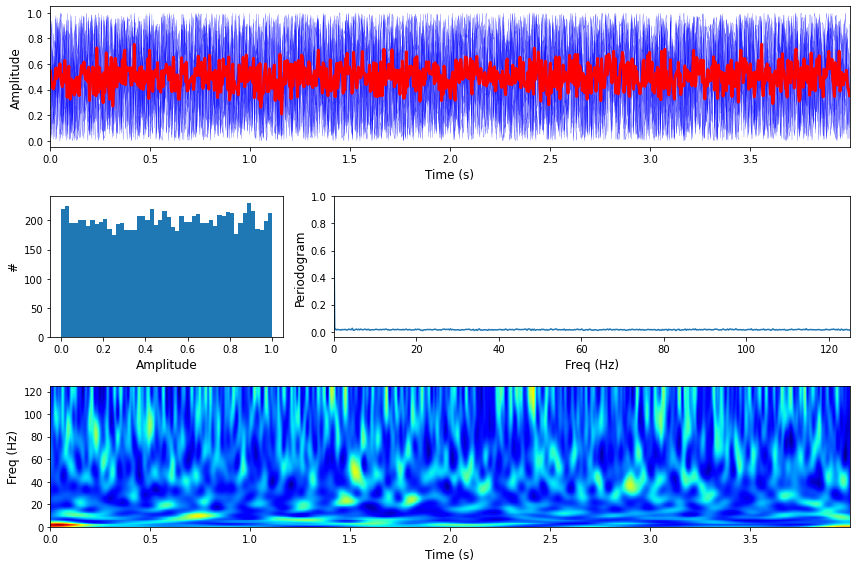

In [5]:
plt.figure(figsize=(12,8))
plot_data(signal, 0,250,1000)

#### Normal

In [6]:
signal = white_noise(trials=10, nvars=1, n=1000, fs=250, amp=1, ntype='normal')

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    0.7s finished


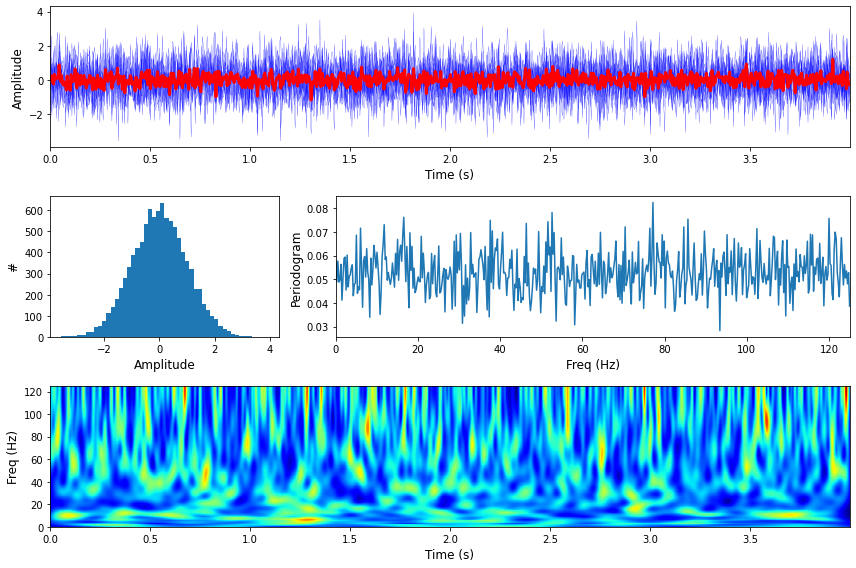

In [7]:
plt.figure(figsize=(12,8))
plot_data(signal, 0,250,1000)

### 2. Pink noise

In [8]:
signal = pink_noise(trials=10, nvars=1, n=1000, fs=250, tau=50)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    0.7s finished


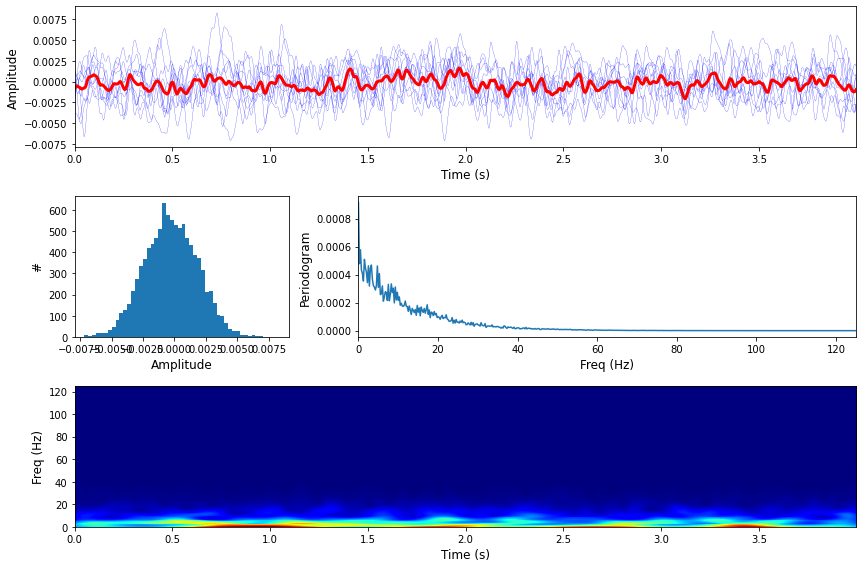

In [9]:
plt.figure(figsize=(12,8))
plot_data(signal, 0,250,1000)

### 3. Ongoing non-stationary signal

In [10]:
signal = ongoing_non_stationary(trials=10, nvars=1, n=1000, fs=250, 
                                peakfreq=np.array([10, 60]), 
                                fwhm=np.array([10, 10]))

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    0.7s finished


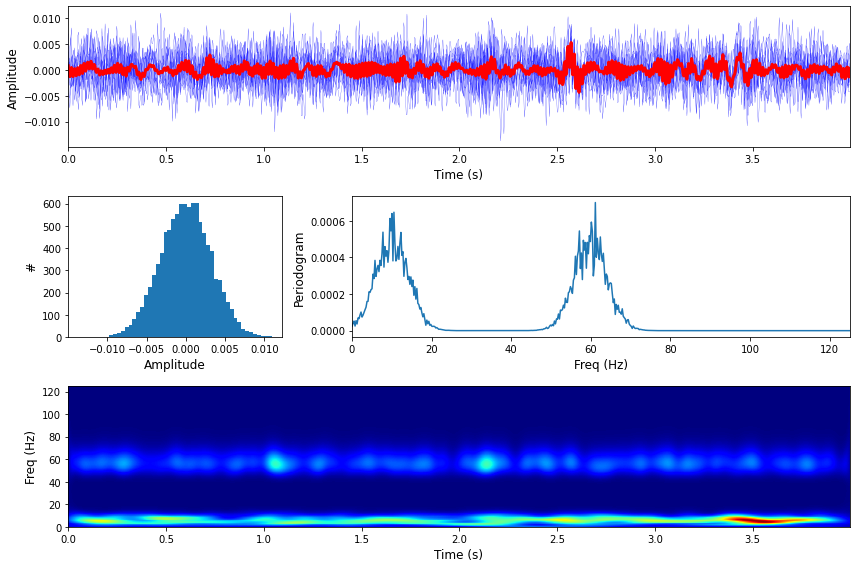

In [11]:
plt.figure(figsize=(12,8))
plot_data(signal, 0,250,1000)

### 4. Transient oscillation with Gaussian

In [12]:
signal = transient_oscillation_gauss(trials=10, nvars=1, n=1000, fs=250, sin_freq=50, 
                                      peaktime=np.array([1,3]), width=np.array([.2,.2]), 
                                      phaselocked=False)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    0.7s finished


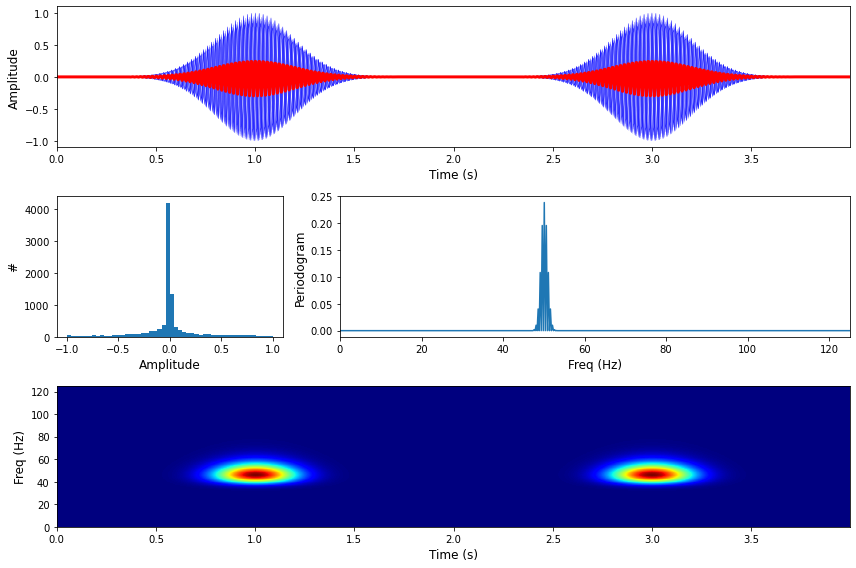

In [13]:
plt.figure(figsize=(12,8))
plot_data(signal, 0,250,1000)

### 5. Transcient non-stationary  signal

In [14]:
signal = transient_oscillation_gauss_non_stationary(trials=10, nvars=1, n=200, fs=60, 
                                                    peakfreq=np.array([21]), fwhm=np.array([5]), 
                                                    peaktime=np.array([1]), width=np.array([0.2]))

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    0.7s finished


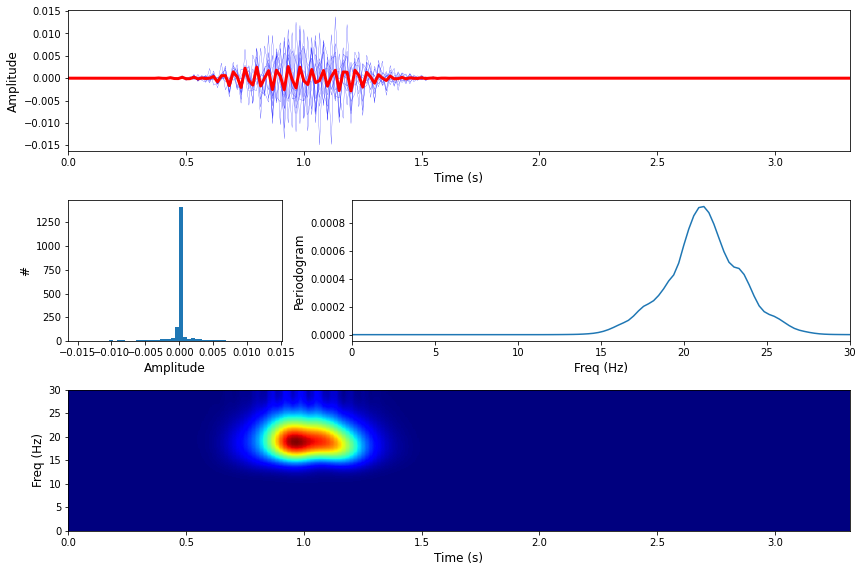

In [15]:
plt.figure(figsize=(12,8))
plot_data(signal,0,60,200)

### Measuring coherence using multitaper technique

To compute the coherence first the cross ($S_{12}(f,t)$), and auto-spectogram ($S_{11}(f,t)$ and $S_{22}(f,t)$) are computed. The coherence is defined as:

$C_{12}(f,t) = \frac{S_{12}S_{12}^{*}}{S_{11}S_{22}}$

However, for the equation above $C_{12}(f,t)=1$ $\forall \text{  } f, \text{ and } t$. Therefore, before taking the ratio in the equation above some temporal and frequency smoothing should be done. To do this, we convolve the auto- and cross-spectogram with a square window of size $w_f$, and $w_rt$, for the frequency and time axis, respectively.

Let's $g(w_t,w_f)$ be the filter, and $\tilde{g}(w_t,w_f)$ its representation in the frequency domain. We can then convolve each spectra with $g$, which gives:

$C_{12}(f,t) = \frac{\tilde{g}*(S_{12}S_{12}^{*})}{\tilde{g}*(S_{11})\tilde{g}*(S_{22})}$

Note that we ommit the dependencies on $f$ and $t$ for the spectra, and on $w_t$ and $w_f$ for the filter.

To estimate the coherence (or spectra) in given bands we can use the multitaper method. Supose that we have the center frequencies of each band $f_c = \{f_{0},\dots, f_{n}\}$, where $n$ is the number of bands, and the bandwidth of each band $\delta f = \{\delta f_{0},\dots,\delta f_{n}\}$.

If $t_b$ is the time bandwidth of the Multitaper transform, the number of cycles can be computed by:

$n_\rm{cycles} = t_b\frac{f_c}{\delta f}$



This can be used to compute the spctra (and the coherence) directly in each band of interest.

First, let's create two signal with localized burts. The first signal with a burst at $1$ s and $3$ s, and the second with a burst only at $3$ s (both with the same width).

In [16]:
T  = 10         # Time interval
fs = 1024       # Sampling frequency
n  = fs*T       # Number of observations

freqs = np.linspace(0.1, 60, 50) # Frequency axis to use on spectral estimation

def gen_signal(T,fs,noise_level=0, seed=0):
    
    np.random.seed(seed)

    x = transient_oscillation_gauss_non_stationary(trials=100, nvars=1, n=n, fs=fs, 
                                                   peakfreq=np.array([21]), fwhm=np.array([5]), 
                                                   peaktime=np.array([4]), width=np.array([.2]))

    y = transient_oscillation_gauss_non_stationary(trials=100, nvars=1, n=n, fs=fs, 
                                                   peakfreq=np.array([21]), fwhm=np.array([5]), 
                                                   peaktime=np.array([4, 8]), width=np.array([.2, 0.2]))

    x_noise = pink_noise(trials=100, nvars=1, n=n, fs=fs, tau=50)
    y_noise = pink_noise(trials=100, nvars=1, n=n, fs=fs, tau=50) 

    signal = xr.DataArray(np.zeros([100,2,n]), dims=("trials", "roi", "time"),
                          coords = {"time": x.time.values})
    signal[:,0,:] = np.squeeze( 10*x.values + noise_level*x_noise.values )
    signal[:,1,:] = np.squeeze( 10*y.values + noise_level*y_noise.values )
    
    return signal

In [17]:
# Signal with pink noise
s = gen_signal(T,fs,noise_level=3, seed=10) 

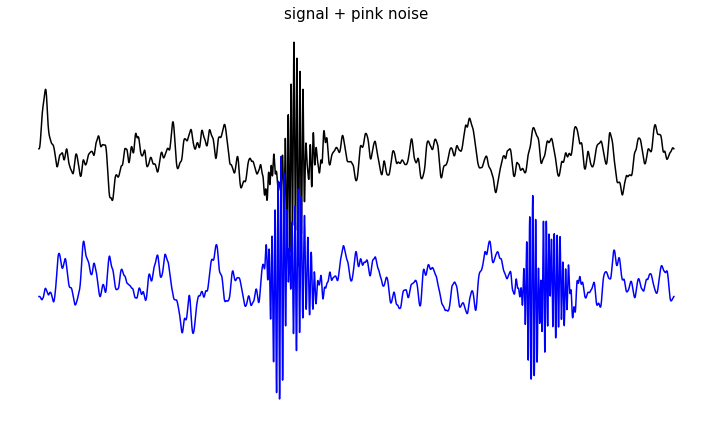

In [18]:
# Plotting ERP of each signal
plt.figure(figsize=(10,6))
plt.plot(s.time, np.squeeze(s.mean(dim="trials")).sel(roi=0), 'k')
plt.plot(s.time, np.squeeze(s.mean(dim="trials")).sel(roi=1)-.0005, 'b')
#plt.legend(['x', 'y'], fontsize=15)
plt.axis('off')
plt.title('signal + pink noise', fontsize=15)
plt.tight_layout()

In [19]:
start = time.time()

# define temporal windows + compute the DFC
n_cycles = freqs / 2.

kw = dict(
    freqs=freqs, times=None, roi=None, foi=None, n_jobs=-1,
    sfreq=fs, mode='multitaper', n_cycles=n_cycles, decim=15,
    sm_times=300, sm_freqs=1, block_size=2
)


coh = conn_coherence_wav(s.values, **kw)

end = time.time()

print('Elapsed time to load super-tensor: ' +str((end - start)) + ' sec.' )

WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise coherence (n_pairs=1, n_freqs=50, decim=15)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.4s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.8s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.8s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

Elapsed time to load super-tensor: 28.471904039382935 sec.


In [20]:
coh = coh.squeeze(dim='roi')

Text(0.5, 0, 'Time [ms]')

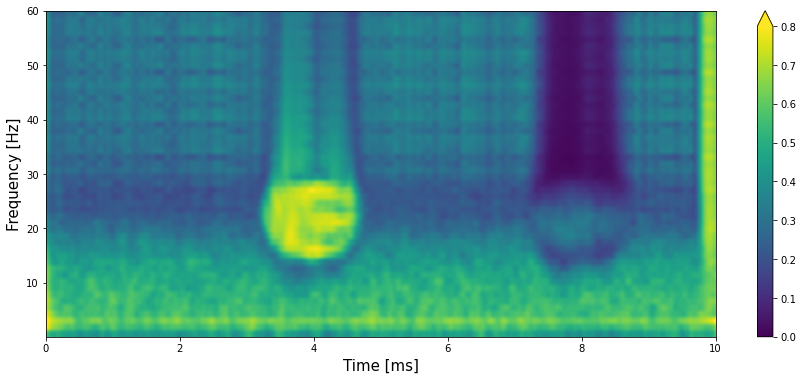

In [21]:
plt.figure(figsize=(15,6))
plt.imshow( np.nanmean(coh, axis=0).squeeze(), aspect='auto', cmap='viridis', origin='lower',
           extent=[0,T,freqs[0],freqs[-1]], vmin=0, vmax=0.8); plt.colorbar(extend="max")
plt.ylabel('Frequency [Hz]', fontsize=15)
plt.xlabel('Time [ms]', fontsize=15)